# Bi-factor CFA for ETS Scale

A Bi-factor CFA is a hierarchical/nested factor analysis. This is used if you are proposing that there is a general factor that influences all items on your scale (ETS), as well as specific factors that influence a subset of items (inclusion, presence, embodiment, wonder). It reflects a theoretical hierarchical structure. 

The general factor is the overarching latent factor that you hypothesize to influence all the observed variables (all scale items). These are typically broad constructs. 

The specific factors are the same as in the first-order CFA, but now they are designed to capture the UNIQUE variance in the item groups BEYOND what is explained by the general factor. 

When to use this? You have a theoretical reason to believe that there is a broad, underlying construct influencing all of the items on the scale. Common examples in psychology would be a general factor of personality, or a general factor of well-being. 

If when doing a first-order CFA you have very high correlations among factors, that may be suggesting that they are all tapping into a shared general construct. 

In [1]:
import pandas as pd
from semopy import Model, Optimizer, calc_stats, inspector, report, semplot

import scaledev
from scaledev import modeler, preprocessor

In [2]:
scaledev.set_pd_display()
data_loc = scaledev.get_data_dir()

# load raw CFA data
df_cfa_raw = pd.read_excel(data_loc / "cfa.xlsx")
df_cfa_raw.head()

# Load the EFA data too, so we have it for comparison
df_efa_raw = pd.read_excel(data_loc / "cleaned_ets.xlsx")

In [3]:
# Start data cleaning
df_cfa = df_cfa_raw.copy()

# Clean up the column names
df_cfa = preprocessor.clean_columns(df_cfa)

# scale items - to use later for filtering down the dataframe
scale_items = [
    c for c in df_cfa.columns if c not in ["frequency", "age", "gender", "ethnicity"]
]

df_cfa = preprocessor.scale_totals(df_cfa, scale_items)

# Bi-factor CFA
CFA requires specifying the model structure upfront, and then seeing if the data fits this specification. It falls under the umbrella of Structural Equation Modeling (SEM). 

In the specification below you will see the note about making the factors uncorrelated. This has to do with this being a bifactor model for CFA. We can talk more about this choice when we meet. 

In [4]:
df_model = df_cfa[scale_items]

model_spec = """
    # General Factor (ETS) - all items load on it
    ETS =~ inclusion1 + inclusion2 + inclusion3 + inclusion4 + inclusion5 + \
            presence1 + presence2 + presence3 + presence4 + presence5 + presence6 + \
            embod1 + embod2 + embod3 + embod4 + embod5 + \
            wonder1 + wonder3
    
    # Specific Factors - items load on their respective factors
    inclusion =~ 1*inclusion1 + inclusion2 + inclusion3 + inclusion4 + inclusion5
    presence =~ 1*presence1 + presence2 + presence3 + presence4 + presence5 + presence6
    embod =~ 1*embod1 + embod2 + embod3 + embod4 + embod5
    wonder =~ 1*wonder1 + wonder3
    
    # General and specific factors are uncorrelated
    ETS ~~ 0*inclusion
    ETS ~~ 0*presence
    ETS ~~ 0*embod
    ETS ~~ 0*wonder

    #The specific factors are also uncorrelated
    inclusion ~~ 0*presence
    inclusion ~~ 0*embod
    inclusion ~~ 0*wonder
    presence ~~ 0*embod
    presence ~~ 0*wonder
    embod ~~ 0*wonder
"""


model = Model(model_spec)
model.fit(df_model, solver="L-BFGS-B")

SolverResult(fun=np.float64(0.9100021916057912), success=True, n_it=68, x=array([0.98979918, 1.17048237, 1.17280182, 0.78777711, 1.04979713,
       0.75950216, 1.12038068, 0.8060323 , 1.19061779, 1.2569198 ,
       0.51313312, 1.37998503, 0.92487225, 1.34543173, 0.48062116,
       1.16016635, 0.43262931, 1.31341102, 0.45006443, 1.01694475,
       1.50560615, 1.60277721, 1.40238466, 1.54505654, 1.42388492,
       1.42872933, 1.33031866, 0.80937418, 1.19591995, 1.3042249 ,
       0.72168449, 0.459937  , 0.42479863, 0.48790185, 0.16372521,
       1.29694914, 0.64602073, 0.64336298, 0.63551357, 1.54364288,
       0.4892792 , 0.46146938, 0.58031823, 0.64821706, 0.52059095,
       0.42565561, 0.76669034, 0.37497774, 0.75744032, 0.92081437,
       0.70538161, 0.31966737, 0.43206244, 0.49990102]), message='CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', name_method='L-BFGS-B', name_obj='MLW')

In [5]:
# Calculate fit statistics
fit_stats = calc_stats(model)

# Add CI for RMSEA to fit stats
lower_rmsea, upper_rmsea = modeler.rmsea_90ci(model)

fit_stats["lower_rmsea"] = lower_rmsea
fit_stats["upper_rmsea"] = upper_rmsea

# Display the fit statistics
fit_stats

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik,lower_rmsea,upper_rmsea
Value,117,153,325.78078,0.00000,4026.77147,0.94610,0.91910,0.89420,0.91910,0.92952,0.07070,106.18000,315.72878,0.91000,0.081,0.095


In [6]:
opt = Optimizer(model)
objective_function_value = opt.optimize()

model_values = inspector.inspect(opt, std_est=True)
model_values

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,inclusion1,~,ETS,1.00000,0.57857,-,-,-
1,inclusion1,~,inclusion,1.00000,0.55603,-,-,-
2,inclusion2,~,ETS,0.98980,0.54918,0.08217,12.04642,0.00000
3,inclusion2,~,inclusion,1.17048,0.62413,0.12464,9.39112,0.00000
4,inclusion3,~,ETS,1.17280,0.65456,0.09629,12.17929,0.00000
5,inclusion3,~,inclusion,0.78778,0.42254,0.09835,8.00973,0.00000
6,inclusion4,~,ETS,1.04980,0.60168,0.09279,11.31336,0.00000
7,inclusion4,~,inclusion,0.75950,0.41834,0.10019,7.58061,0.00000
8,inclusion5,~,ETS,1.12038,0.64824,0.09103,12.30811,0.00000
9,inclusion5,~,inclusion,0.80603,0.44819,0.09636,8.36453,0.00000


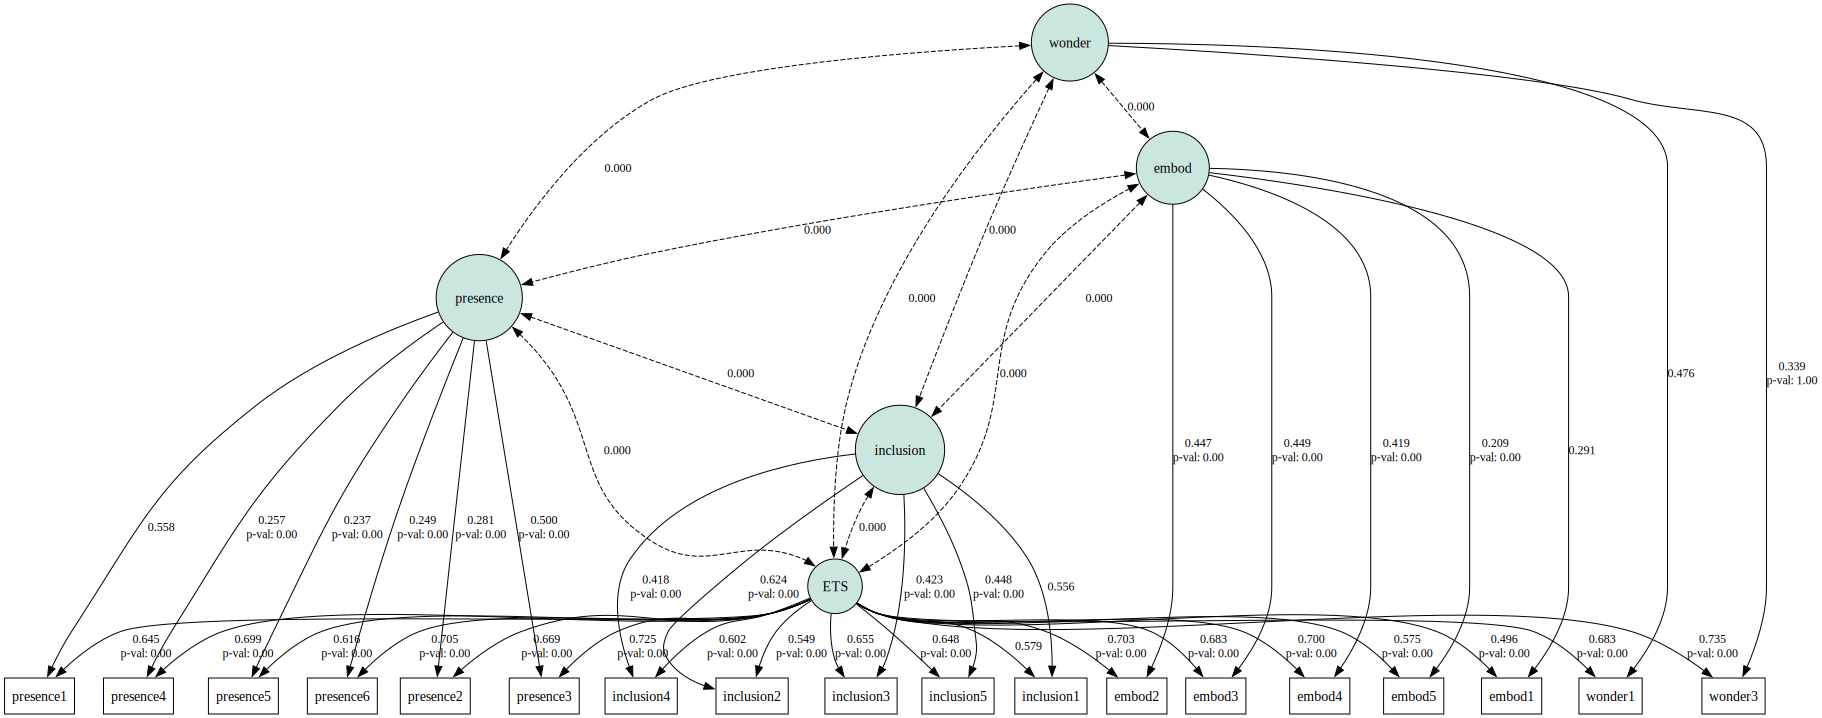

In [7]:
# path diagram
semplot(
    mod=model,
    plot_covs=True,
    std_ests=True,
    filename="plots/cfa_model_plot_bifactor.png",
)

In [8]:
# Save out an html report for the CFA
report(model=model, name="ETS Scale Bi-factor", std_est=True)